# TRocr fine-tuning & evaluation

emulated from: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Evaluating_TrOCR_base_handwritten_on_the_IAM_test_set.ipynb?pli=1&authuser=1#scrollTo=Nkaki4CgZJNw

In [1]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset
from PIL import Image

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from torch.utils.data import DataLoader

from datasets import load_metric
from difflib import SequenceMatcher
import mlflow

# fine-tuning dependencies
from sklearn.model_selection import train_test_split

Experiment parameters (log these to MLflow)

In [90]:
DATA_DIR = '/home/riikoro/fossil_data/tooth_samples'
DATA_VERSIONS = [1, 2]
MAX_TARGET_LENGTH = 64 
MODEL = 'microsoft/trocr-large-handwritten'
BATCH_SIZE = 2
NUM_EPOCHS = 3 
LEARNING_RATE = 5e-4 # changed from -5 to speed up convergence

In [3]:
dfs = []
for version in DATA_VERSIONS:
    df = pd.read_csv(os.path.join(DATA_DIR, f'v{version}', 'labels.tsv'), sep='\t')
    df['filename'] = f'v{version}/' + df['filename']
    dfs.append(df)
# label_dfs = [ for data_dir in data_dirs]
# label_dfs[0].head()
# TODO: read v2 labels
label_df = pd.concat(dfs, axis=0).reset_index()
label_df

,index,filename,text
0,0,v1/0.png,Distal half left humerus with broken medial
1,1,v1/1.png,Isolated
2,2,v1/2.png,"LI2̌, RM̱2̌ & tooth frags (8)"
3,3,v1/3.png,LM2̌
4,4,v1/4.png,right maxilla with frag of zygomatic and
...,...,...,...
94,27,v2/28.png,Px̄ frag.
95,28,v2/29.png,Prox. phalanx
96,29,v2/30.png,Edentulous md. (2 unassoc. elemen
97,30,v2/31.png,Prox. intermediate phal


In [4]:
print(label_df['text'][0])

Distal half left humerus with broken medial


In [5]:
class FossilDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['filename'][idx]
        text = self.df['text'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(os.path.join(self.root_dir, file_name)).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [92]:
processor = TrOCRProcessor.from_pretrained(MODEL)
test_dataset = FossilDataset(root_dir=DATA_DIR, df=label_df, processor=processor, max_target_length=MAX_TARGET_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [93]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 384, 384])
labels torch.Size([2, 64])


In [94]:
labels = batch["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.batch_decode(labels, skip_special_tokens=True)
label_str

['Distal half left humerus with broken medial', 'Isolated']

## Evaluate

In [99]:
device = 'cpu' # no gpu available

# model = VisionEncoderDecoderModel.from_pretrained(MODEL) # for initial, untuned model
model = VisionEncoderDecoderModel.from_pretrained('./output/') # the fine-tuned model
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

In [100]:
cer = load_metric("cer")

In [101]:
from tqdm.notebook import tqdm

print("Running evaluation...")

predictions = []
for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to(device)
    outputs = model.generate(pixel_values, max_new_tokens=MAX_TARGET_LENGTH)

    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    print(pred_str)
    predictions.append(pred_str)
    labels = batch["labels"]
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)
    print(label_str)

    # add batch to metric
    cer.add_batch(predictions=pred_str, references=label_str)

final_score = cer.compute()

Running evaluation...


  0%|          | 0/50 [00:00<?, ?it/s]

['Isolated with humal', 'Isolated']
['Distal half left humerus with broken medial', 'Isolated']
['Lt. LM1�', 'LM2�']
['LI2̌, RM̱2̌ & tooth frags (8)', 'LM2̌']
[' right right rightfragal', 'Isolated']
['right maxilla with frag of zygomatic and', 'Isolated']
['alterior', 'fral']
['anterior', 'man']
['Isolated R2̌��', 'LeftLeft end with P4̌']
['Isolated RC̱, RP4̱̂, RM', 'Left mandible frag with broken P4̌, M1̌ and']
['Isolated', 'R2̂�']
['Isolated', 'M3̂']
['Isolated fragag with', 'Shaft lacking humal']
['frag wi I2̄̌ alveolus, croots P3̄̌-M2̄̌', 'Shaft lacking distal & proximal ends']
['fragible humal�', 'proximal right right']
['Frag left mandibular corpus lacking teeth', 'proximal frag. right ulna']
['L mandible frag with muš��', 'A1̌ humal']
['L mandible frag with roots M2̌-̌3̌', 'A: 4 upper premolar (P3̱̌) unerrupted. L. mbs']
['frag. proximal', 'Rt.']
['frag. right ulna proximal erd. wt. shaft.', 'lokote']
['fragible humus�', '']
['A = frag left mandible corpus with M3̌ roots', 'M3

In [104]:
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

def sequence_matcher_score(labels, predicted_labels):
    similarities = np.array([0.0] * len(labels))
    for i in range(len(labels)):
        similarities[i] = similarity(predicted_labels[i], labels[i])
    return np.mean(similarities)

predicted_labels = []
for pred_batch in predictions:
    predicted_labels.extend(pred_batch)

labels = list(label_df['text'])
print('correct:   ' + ', '.join(labels))
print('predicted: ' + ', '.join(predicted_labels))
print("Character error rate on test set:", final_score)
sequence_score = sequence_matcher_score(labels, predicted_labels)
print(f"Sequence matcher score, baseline: {sequence_score}")

correct:   Distal half left humerus with broken medial, Isolated, LI2̌, RM̱2̌ & tooth frags (8), LM2̌, right maxilla with frag of zygomatic and, Isolated, anterior, man, Isolated RC̱, RP4̱̂, RM, Left mandible frag with broken P4̌, M1̌ and, Isolated, M3̂, frag wi I2̄̌ alveolus, croots P3̄̌-M2̄̌, Shaft lacking distal & proximal ends, Frag left mandibular corpus lacking teeth, proximal frag. right ulna, L mandible frag with roots M2̌-̌3̌, A: 4 upper premolar (P3̱̌) unerrupted. L. mbs, frag. right ulna proximal erd. wt. shaft., lokote, A = frag left mandible corpus with M3̌ roots, M3̂, RT.mandible frag with P4̌-M2̌, Mandible lacking left ascending ramus;, Rt P4̄̌, LM1̂, Broken molar !(M̱), Isolated RM2̌, RM3̌, broken LM3̌, L mandible frag with M1̌-̌3̌, Proximal part right femur, A= R mandible with M2̄̌-̌3̄̌ M1̌ root, Left ulna lacking distal epiphysis, A = distal end left femur, Rt., proximal, Proximal & distal end right femur, Right humerus lacking prox. epiphysis, Left mandible frag with

In [105]:
# save evaluation labels & predicted labels to files to visually inspect differences
with open('output/predicted_labels.txt', 'w') as file:
    file.write('\n'.join(predicted_labels))


## MLflow

In [106]:
%env MLFLOW_TRACKING_URI=sqlite:///mlflow.db
# %env MLFLOW_ARTIFACTS_URI=/home/riikoro/thesis/code/mlartifacts
mlflow.set_experiment("Dental element OCR")
mlflow.set_tracking_uri("sqlite:///mlflow.db")

params = {
    'data_versions': DATA_VERSIONS,
    'max_new_tokens': MAX_TARGET_LENGTH,
    'model': MODEL,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("sequence matcher score", sequence_score)
    mlflow.log_metric('cer', final_score)

    # Log output files (predicted labels & model)
    mlflow.log_artifacts('./output')

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "TRocr tuned by freezing all weights except the last layer of the encoder/decoder, emulated from https://github.com/NielsRogge/Transformers-Tutorials")

env: MLFLOW_TRACKING_URI=sqlite:///mlflow.db


# Fine-tune

from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb

In [56]:
train_df, test_df = train_test_split(label_df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [57]:
train_dataset = FossilDataset(root_dir=DATA_DIR, df=train_df, processor=processor, max_target_length=MAX_TARGET_LENGTH)
eval_dataset = FossilDataset(root_dir=DATA_DIR, df=test_df, processor=processor, max_target_length=MAX_TARGET_LENGTH)
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 79
Number of validation examples: 20


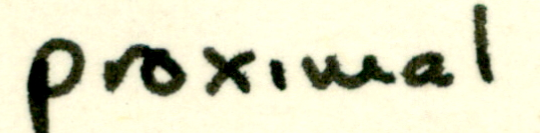

In [58]:
image = Image.open(train_dataset.root_dir +'/' + train_df['filename'][0]).convert("RGB")
image

In [59]:
encoding = train_dataset[0]
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

proximal


In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)

In [63]:
# not changed from tutorial, TODO: figure out vocabulary
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [65]:
cer_metric = load_metric("cer")

def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [75]:
# count layers
layer_count = len([layer for layer in model.named_parameters()])
layer_count

636

In [77]:
# freeze all but last layer
for i, (name, weights) in enumerate(model.named_parameters()):
    if i < layer_count - 1:
        weights.requires_grad = False 

print([layer.requires_grad for layer in model.parameters()])


[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [91]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

            # forward + backward + optimize
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer

    print("Validation CER:", valid_cer / len(eval_dataloader))


  0%|          | 0/40 [00:00<?, ?it/s]

Loss after epoch 0: 4.954802327603102


  0%|          | 0/10 [00:00<?, ?it/s]

['Lt. LM1�', 'L mandible frag with muš��']
['LI2̌, RM̱2̌ & tooth frags (8)', 'L mandible frag with roots M2̌-̌3̌']
['Proxolar frag. P3̱', 'LM2�']
['Premolar frag -? P3̌', 'LM2̌']
['Isolated', 'Rt.']
['Isolated L.C̱, RM3̱̂, LM3̱̂, LM2̱̂, LM3̌', '? Rt. Md. frag. wt Px̄']
['Prox.', 'Lt. Mt. with P4̱�����']
['P3̱̂ frag. (Crown)', 'Lt. Md. frag. wt dP3̄̌, P4̄̌-M1̄̌']
['Distal right humus', 'M2�']
['Distal half right humerus', 'Molar frag.']
['Prox. frag.', 'Lt. frag.']
['? P4̱̂ frag.', 'Lt. C̱ frag.']
['LM mandible frag with M1̌', 'Maudible lacking']
['L mandible frag with M1̌-̌3̌', 'Mandible lacking left ascending ramus;']
['proximal right right', ' humer ( ( Complete (']
['proximal frag. right ulna', 'Humerus (Complete)']
['Prox.', 'mus frag with2�']
['P3̌ Crown', 'max frag with 1/2M2̂-M3̂']
['Prox (', 'R. Crox�']
['P3̄̌ (Crown)', 'R.C̄root']
Validation CER: 0.5242795496429494


  0%|          | 0/40 [00:00<?, ?it/s]

Loss after epoch 1: 5.026505880057812


  0%|          | 0/10 [00:00<?, ?it/s]

['Lt. LM1�', 'L mandible frag with muš��']
['LI2̌, RM̱2̌ & tooth frags (8)', 'L mandible frag with roots M2̌-̌3̌']
['Proxolar frag. P3̱', 'LM2�']
['Premolar frag -? P3̌', 'LM2̌']
['Isolated', 'Rt. frag with P4�']
['Isolated L.C̱, RM3̱̂, LM3̱̂, LM2̱̂, LM3̌', '? Rt. Md. frag. wt Px̄']
['Prox. Crag.', 'Lt. Mt. with P4�̱������']
['P3̱̂ frag. (Crown)', 'Lt. Md. frag. wt dP3̄̌, P4̄̌-M1̄̌']
['Distal right humus', 'M2�']
['Distal half right humerus', 'Molar frag.']
['Prox. frag.', 'Lt. frag.']
['? P4̱̂ frag.', 'Lt. C̱ frag.']
['LM mandible frag with M1̌', 'Maudible lacking']
['L mandible frag with M1̌-̌3̌', 'Mandible lacking left ascending ramus;']
['proximal right right', ' humer ( ( Complete (']
['proximal frag. right ulna', 'Humerus (Complete)']
['Prox.', 'mus frag with2�']
['P3̌ Crown', 'max frag with 1/2M2̂-M3̂']
['Prox (', 'R. Crox�']
['P3̄̌ (Crown)', 'R.C̄root']
Validation CER: 0.5074547552090468


  0%|          | 0/40 [00:00<?, ?it/s]

Loss after epoch 2: 4.858761613070965


  0%|          | 0/10 [00:00<?, ?it/s]

['Lt. LM1�', 'L mandible frag with muš��']
['LI2̌, RM̱2̌ & tooth frags (8)', 'L mandible frag with roots M2̌-̌3̌']
['Proxolar frag. P3̱', 'LM2�']
['Premolar frag -? P3̌', 'LM2̌']
['Isolated RM1� LM3� LM1�LM3�', 'Rt. frag with P4�']
['Isolated L.C̱, RM3̱̂, LM3̱̂, LM2̱̂, LM3̌', '? Rt. Md. frag. wt Px̄']
['Prox. Crag.', 'Lt. Mt. with P4�̱��������']
['P3̱̂ frag. (Crown)', 'Lt. Md. frag. wt dP3̄̌, P4̄̌-M1̄̌']
['Distal right humerus', 'M2�']
['Distal half right humerus', 'Molar frag.']
['Prox. frag.', 'Lt. frag.']
['? P4̱̂ frag.', 'Lt. C̱ frag.']
['LM mandible frag with M1̌', 'Maudible lacking']
['L mandible frag with M1̌-̌3̌', 'Mandible lacking left ascending ramus;']
['proximal right right', ' humer ( ( Complete (']
['proximal frag. right ulna', 'Humerus (Complete)']
['Prox.', 'mus frag with2�']
['P3̌ Crown', 'max frag with 1/2M2̂-M3̂']
['Prox (', 'R. Crox�']
['P3̄̌ (Crown)', 'R.C̄root']
Validation CER: 0.4828922420317328


## To investigate

- what exactly is the evaluation metric? is is sum of cross-entropy of character probabilities? if so, can I give the character set in the model to include the special characters I have? probability of being subscript/superscript/top low macron?

In [96]:

model.save_pretrained("./output")